# **Assignment of Andrea GHIGLIONE**

> # **0.A**
> ### **Downloading, creating test set**







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.linalg

np.random.seed(42)

In [ ]:
df = pd.read_csv("data/train.csv")  # upload training only since test has no labels

In [ ]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [ ]:
# Drop ID_code since it is not useful information
df = df.drop(columns=["ID_code"])

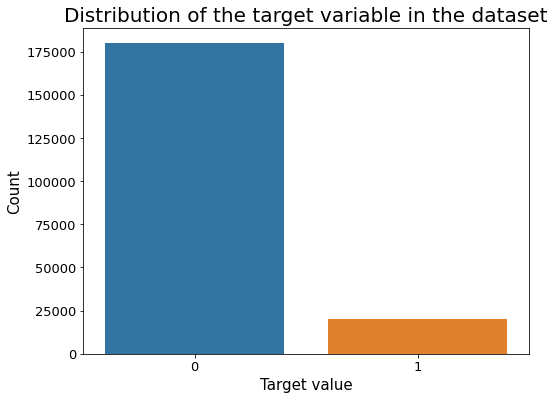

In [ ]:
# plot distributions of target variable
plt.figure(figsize=(8,6))
plt.title("Distribution of the target variable in the dataset", fontsize=20)
sns.countplot(x=df["target"])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Target value", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [ ]:
# Split the dataset into train and test, 50/50
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df.drop(columns=["target"]), df["target"], test_size=0.5, 
                                                            stratify=df["target"], random_state=42)

In [ ]:
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy()
y_test = y_test_df.to_numpy()

In [ ]:
print(f"The training dataset contains {X_train.shape[0]} records")
print(f"The test dataset contains {X_test.shape[0]} records")
print(f"Each record has {X_train.shape[1]} features")

The training dataset contains 100000 records
The test dataset contains 100000 records
Each record has 200 features


> # **0.B**
> ### **Distribution of class labels and input dimensionality**

**We can see that the dataset is highly imbalanced in terms of class labels:**
this is important to notice since it allows me to understand that accuracy is NOT a good metric to use. If I would take a dummy model which predicts always the class 0 I would get an accuracy of roughly 90% since the class 0 covers around the 90% of the data. For that reason I should look for other metrics to really assess the quality of the final model, such as precision, recall, f1-score. It would be useful to plot a confusion matrix.

**Input dimensionality:** 
There is an high number of features so a problem to be considered is the $\textit{curse of dimensionality}$ where data points are sparse, distances among them are bigger and training is longer.
Also, I can see that the number of records (N) is much higher than the number of features (D), this is generally good when doing a linear regression, otherwise the closed form MLE solution of the regression problem would be ill-posed. In particular $\mathbf{X}^\top\mathbf{X}$ would be low rank and so some of its eigenvalues would be 0 (positive semi-definite instead of positive definite). For example, If I have 2 points and 3 dimensions I would have infinite hyperplanes that could model these data.
However the matrix inversion cost is very high with high dimensional data, in particular inverting a matrix $(D, D)$ costs $O(D^{3})$.
Note: in case of $D > N$ Gaussian processes would be a good solution (inverting costs $O(N^{3})$)

# EDA - Exploratory Data Analysis

Visualizing training and test target variable distribution

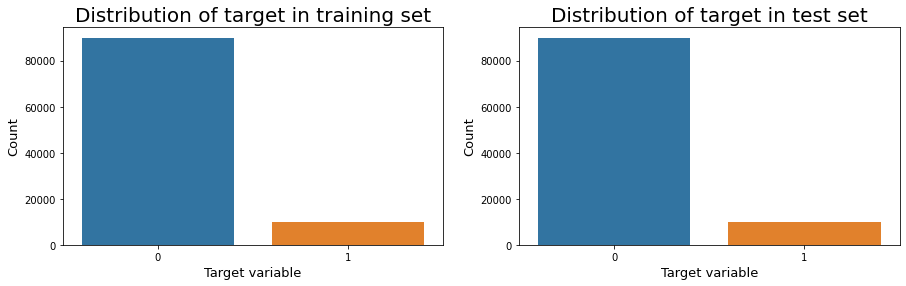

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Distribution of target in training set", fontsize=20)
ax[0].set_xlabel("Target variable", fontsize=13)
ax[0].set_ylabel("Count", fontsize=13)
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title("Distribution of target in test set", fontsize=20)
ax[1].set_xlabel("Target variable", fontsize=13)
ax[1].set_ylabel("Count", fontsize=13)
plt.show()

> # **1.A**
> ### **Bayesian Linear Regression**

I define the prior over the model parameters $\mathbf{w}$ as 

\begin{equation}
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{S}) 
\end{equation}

I assume the covariance matrix $\mathbf{S}$ to be diagonal $\mathbf{S} = \sigma_\mathrm{w}^2\mathbf{I}$.

Also, since the likelihood is defined as $p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma_\mathrm{n}^2\mathbf{I})$
then the posterior is analitic and follows this form:

\begin{equation}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) = \mathcal{N}\left(\mathbf{\mu}, \mathbf{\Sigma} \right)
\end{equation}

where $\mathbf{\mu} = \frac{1}{\sigma^2_\mathrm{n}}\mathbf{\Sigma}\mathbf{X}^\top\mathbf{y}$

and $\mathbf{\Sigma}^{-1} = \left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}  \right)$.

In [ ]:
def cholesky(A):
    L = np.linalg.cholesky(A)
    x = np.linalg.solve(L, np.eye(A.shape[0]))
    return np.linalg.solve(L.T, x)


def compute_posterior(X, y, sw2, sn2):
    '''
    Compute posterior parameters; covariance and mean
    '''
    S = sw2 * np.eye(X.shape[1])
    # Use Cholesky for the inverse
    sigma_inv = (1/sn2)*(X.T @ X + cholesky(S))
    sigma = cholesky(sigma_inv)
    w_posterior_cov = sigma
    w_posterior_cov = np.linalg.inv(1 / sn2 * X.T @ X + np.linalg.inv(S))
    w_posterior_mean = 1 / sn2 * w_posterior_cov @ X.T @ y
    return w_posterior_mean, w_posterior_cov

I know from theory that the **predictive distribution** is:

$p(\mathbf{y}_\mathrm{*}|\mathbf{X}, \mathbf{y}, \mathbf{x}_\mathrm{*}, \sigma^2_\mathrm{n}) = \mathcal{N}(\mathbf{x}_\mathrm{*}^\top\mathbf{\mu}, \sigma^2_\mathrm{n} + \mathbf{x}_\mathrm{*}^\top\mathbf{\Sigma}\mathbf{x}_\mathrm{*})$, where $\mathbf{\mu}$ and $\mathbf{\Sigma}$ are the posterior mean and covariance.

In [ ]:
def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = xt_i.T @ w_mean
        yt_i_var = sn2 + xt_i.T @ w_cov @ xt_i
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )

    return yt_mean, yt_var

I could also sample from the posterior of the weights

In [ ]:
def sample(Xt, w_mean, w_cov, sn2, N):
    def _sample_single(Xt, w_mean, w_cov, sn2):
        w_sample = np.random.multivariate_normal(mean=w_mean, cov=w_cov)
        y_sample = Xt @ w_sample
        return y_sample

    samples = np.zeros((N, len(Xt)))
    for i in range(N):
        samples[i] = _sample_single(Xt, w_mean, w_cov, sn2)
    return samples

> # **1.B**
> ### **Pre-processing**

First I have to deal with **null values** (if any)

In [ ]:
X_train_df.isna().sum().sum()

0

There are no null values, otherwise I would have considered to drop records with null values or I would have looked for filling them.

Now I look for duplicates which may affect the result. Generally the same information appearing two times is misleading (with some exceptions like time series, etc.) , but apparently in this dataset I can safely drop them in order to obtain a model that will be able to generalize better.

In [ ]:
X_train_df.duplicated().sum()

0

There are no duplicates hence there is no need to drop any record.

Check null values in test (I would not drop eventual duplicates in test since this set is used for predictions). In case there are null values I may consider to fill them, but again I can NOT drop test records.

In [ ]:
X_test_df.isna().sum().sum()

0

I check correlations (Pearson coefficient) between variables; in case some of them are strongly correlated I can drop them.

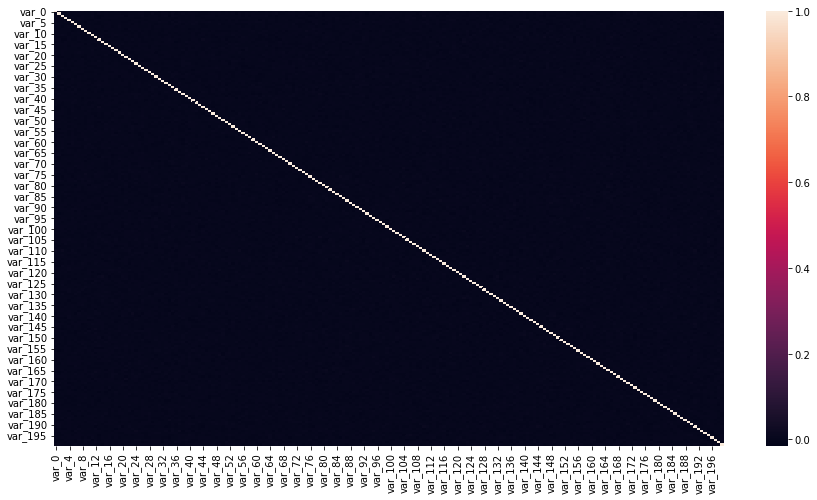

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train_df.corr())
plt.show()

No correlation, hence I do not have to drop features here

Now, it is important to highlight that **standardization** is needed since in this way all the features will have the same importance. In addition, this makes the training faster.
Also, since the dataset is highly imbalanced it could be useful to **balance** it in order to let the model generalize better (SMOTE could be used).

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

Also, since the dataset has many features, I can apply PCA to reduce dimensionality. When using it it's very useful to look at the cumulative plot of variance explained by components.

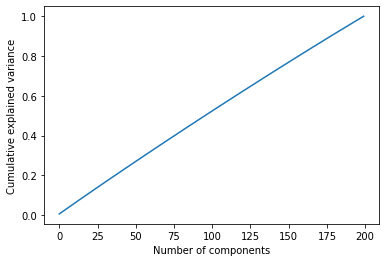

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit(X_train_sc)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

I can see from the above plot that each feature explains the same amount of variance hence I can't drop any significant amount of features, so I won't perform PCA.

In [ ]:
X_train = X_train_sc
X_test = sc.transform(X_test)

> # **1.C**
> ### **Apply regression, calculate weights' posterior variance**

I assume the noise variance $\sigma_\mathrm{n}$ and weight variance $\sigma_\mathrm{w}$ to be small. Polynomial order is 1 since there already many features per data point.

In [ ]:
sn2, sw2 = 1, 1
w_posterior_mean, w_posterior_cov = compute_posterior(X_train_sc, y_train, sw2, sn2)

Report weight's posterior variance

In [ ]:
# weight's posterior variance
np.diag(w_posterior_cov)

array([1.00261163e-05, 1.00215516e-05, 1.00264973e-05, 1.00149075e-05,
       1.00212549e-05, 1.00234412e-05, 1.00274208e-05, 1.00166243e-05,
       1.00179813e-05, 1.00245457e-05, 1.00189897e-05, 1.00224053e-05,
       1.00275263e-05, 1.00238226e-05, 1.00210749e-05, 1.00209205e-05,
       1.00178249e-05, 1.00190079e-05, 1.00211438e-05, 1.00179746e-05,
       1.00209435e-05, 1.00221107e-05, 1.00236129e-05, 1.00198192e-05,
       1.00221469e-05, 1.00197484e-05, 1.00241570e-05, 1.00160614e-05,
       1.00181968e-05, 1.00195776e-05, 1.00202074e-05, 1.00202791e-05,
       1.00204179e-05, 1.00217035e-05, 1.00302687e-05, 1.00240086e-05,
       1.00271432e-05, 1.00185136e-05, 1.00246770e-05, 1.00223925e-05,
       1.00238380e-05, 1.00189718e-05, 1.00189440e-05, 1.00246456e-05,
       1.00214392e-05, 1.00186495e-05, 1.00216707e-05, 1.00195068e-05,
       1.00220001e-05, 1.00178220e-05, 1.00192767e-05, 1.00252221e-05,
       1.00199124e-05, 1.00200395e-05, 1.00201796e-05, 1.00216323e-05,
      

> # **1.D**
> ### **Discretizing predictions and plotting confusion matrix**

A simple way to discretize predictions is to set a threshold that will determine either class 0 or class 1. A first idea could be to set this threshold at 0.5, however it is better to use the **ROC curve** choosing the best threshold in terms of TPR - FPR.

TPR (sensitivity) is the True Positive Rate and it corresponds to the probability that an actual positive data point will be tested as positive.

FPR (false alarm ratio) is the True Positive Rate and it corresponds to the probability that false allarm will be raised.

In [ ]:
y_mean, y_var = compute_predictive(X_test, w_posterior_mean, w_posterior_cov, sn2)

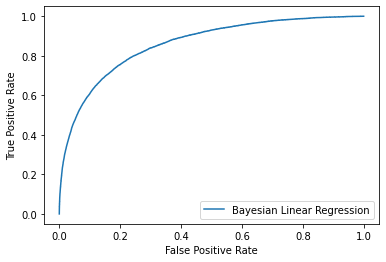

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, f1_score

fpr, tpr, thresholds = roc_curve(y_test, y_mean)
plt.plot(fpr, tpr,  label='Bayesian Linear Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

Print accuracy and f1-score (weighted average of precision and recall)

In [ ]:
y_pred_lin = y_mean
print(f"The optimal threshold is at {optimal_threshold:.2f}")
# if above the optimal threshold it is mapped to 1, otherwise 0
y_pred = y_pred_lin >= optimal_threshold
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred):.2f}")

The optimal threshold is at 0.07
Accuracy score: 0.78
F1 score: 0.41


Plot confusion matrix to understand how are predictions with respect to true labels.

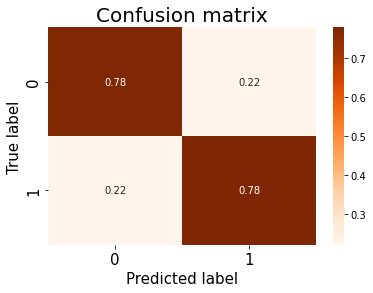

In [ ]:
from sklearn.metrics import confusion_matrix

# I normalize values for readability
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="Oranges")
plt.title("Confusion matrix", fontsize=20)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Bayesian Logistic Regression

> # **2.A**
> ### **Markov Chain Monte Carlo inference**

Logistic and densities utils below

In [ ]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

# I will use Bernoulli likelihood
def bernoulli_density(y, p):
    return y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10)  # 1e-10 to avoid ill-posed expression

def gaussian_density(x, mean=0, var=1):
    return - 0.5 * (np.log(2 * np.pi * var) + (x - mean)**2 / var)

Function to compute the unnormalized logdensity $g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})$

In [ ]:
def logposterior(w, X, y):
    # get the prior
    prior = gaussian_density(w)
    p = logistic(X @ w)
    bern_log_lik = bernoulli_density(y, p)

    return np.sum(bern_log_lik) + np.sum(prior)

Now I can implement the Random walk with Metropolis-Hastings correction

In [ ]:
def rw_mh_step(w_prev, X, y, step_size):
    ws_tilde = np.random.multivariate_normal(w_prev, np.eye(len(w_prev)) * step_size)
    # Now I have to compute the ratio
    r = np.exp(logposterior(ws_tilde, X, y) - logposterior(w_prev, X, y))
    if r >= 1:
        return ws_tilde
    else:
        u = np.random.uniform(0,1)
        if u <= r:
            return ws_tilde
        else:
            return w_prev

Below I implement a function to run the sampling for a certain number of iterations

In [ ]:
def run_sampling(w, X, y, n_samples, step_size=1):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in tqdm(range(n_samples), desc="MH"):
        w = rw_mh_step(w, X, y, step_size)
        samples[i] = w
    
    return samples

Now, I can run the Metropolis-Hastings algorithm. 

In [ ]:
from tqdm.notebook import tqdm

X_train = X_train_sc
# After a manual grid search I found that a good value for the step_size is 0.0001

# take w_init randomly
w_init = np.random.rand((X_train.shape[1]))
# I set the number of samples at 10000 like in the lab, no burn-in here
samples = run_sampling(w_init, X_train, y_train, n_samples=10000, step_size=0.0001)

MH:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Plot some traces

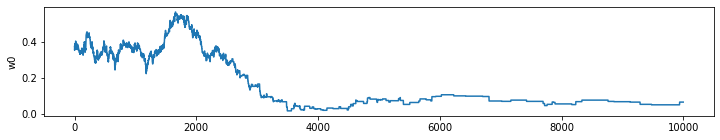

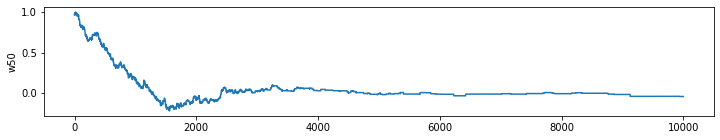

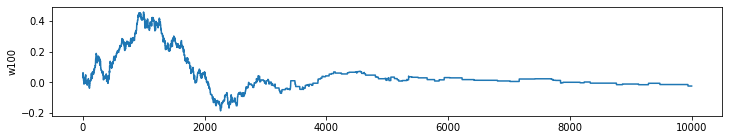

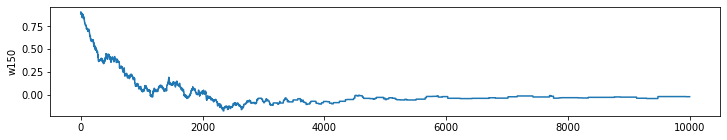

In [ ]:
wi = np.arange(stop=200, step=50)  # plot 4 traces
for i in wi:
    plt.figure(figsize=(12,2))
    plt.plot(list(range(0, samples.shape[0])), samples[:, i])
    plt.ylabel(f"w{i}")
    plt.show()

I notice that a burn-in of around 4500 samples might be ok

In [ ]:
burn_in = 4500
samples_bi = samples[burn_in: , :]

> # **2.B**
> ### **Variational approximation**

A way to approximate the intractable posterior (other methods we saw are MAP and Laplace approximation)

In [ ]:
import jax
import jax.numpy as jnp
from functools import partial
from typing import NamedTuple

def bernoulli_density(y, p):
    offset = 1e-10
    return y * jnp.log(p + offset) + (1 - y) * jnp.log(1 - p + offset)

Work with a transformed version of the parameters through logarithm to avoid that the optimisation algorithm will attempt to evaluate log-likelihood in regions of parameter space where some of these parameters are negative (so there will be numerical issues).

In [ ]:
class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

Function to resample once using the parametrization trick

In [ ]:
def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    # I need to take the exponential since I work with the log transformed version
    var = jnp.exp(log_var)
    sigma = jnp.sqrt(var)
    eps = jax.random.normal(key=rng, shape=sigma.shape) 
    return mean + sigma * eps

Below there is a function to compute the Kullback-Leibler divergence between two gaussians with diagonal covariance. In particular:

$$
\mathrm{KL}[q || p] =  \frac{1}{2} \sum\left( \log \frac{\sigma^2_p}{\sigma^2_q} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \right)
$$

In [ ]:
def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params
    kl = 0.5 * jnp.sum(log_var_p - log_var_q + (jnp.exp(log_var_q) + jnp.square(mean_q - mean_p)) / jnp.exp(log_var_p) - 1)
    return kl

Logistic regression model utils

In [ ]:
def logistic(z):
    return 1 / (1 + jnp.exp(-z))

def model(w, X):
    return logistic(X @ w)

Now I define the variational objective which is:

$$
      \mathcal{L}(\theta) = \mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) -\mathbb{E}_\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]
$$


In [ ]:
def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """
        # Get one sample of w using the sample_fn and the parameters of q
        w = sample_fn(rng, q_params)
        # Predict the output using the sample before
        yp = model(w, X)
        # Compute the likelihood and return it
        return likelihood_fn(y, yp)

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng, q_params, X, y)
        # Compute the expectation (i.e. take the mean)
        expected_likelihood = jnp.mean(jnp.sum(likelihood_vals, axis=1))
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params, p_params)
        # Compute the ELBO
        elbo = expected_likelihood - kl
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,
    kl_divergence_fn=kl_diag_diag,
    likelihood_fn=bernoulli_density
)

Compute variational objective

In [ ]:
D = X_train.shape[1]
p_params = GaussianDiagonal(
                            jnp.zeros(D), 
                            jnp.zeros(D)  # log of ones -> zeros
                            )  
q_params = GaussianDiagonal(jnp.zeros(D), jnp.zeros(D))
rng = jax.random.PRNGKey(0)
elbo, (likelihood, kl) = elbo_fn(q_params, p_params, rng, X_train, y_train)
print("ELBO =", elbo)
print("Likelihood =", likelihood)
print("KL =", kl)

ELBO = -559682.1
Likelihood = -559682.1
KL = 0.0


Now, since I don't have the analytical formula for the variational objective, but I can only access samples, I will do as in the lab: I will try to sample using 100 different random seeds the ELBO with [2, 10, 100, 1000] Monte Carlo samples plotting their distribution through box plots.

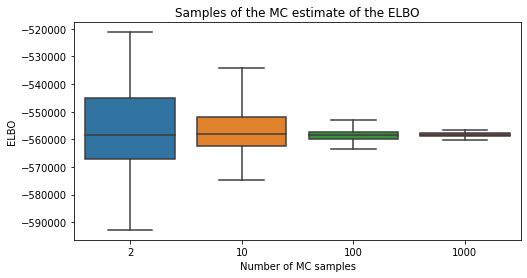

In [ ]:
elbo_samples = pd.DataFrame()
n_repetition = 100

for Nmc in [2, 10, 100, 1000]:
    elbo_samples[Nmc] = np.stack(
        [
            elbo_fn(q_params, p_params, jax.random.PRNGKey(i), X_train, y_train, Nmc=Nmc)[0]
            for i in range(n_repetition)
        ]
    )


fig, ax = plt.subplots(figsize=[8, 4])
sns.boxplot(data=elbo_samples, whis=np.inf)
ax.set_title("Samples of the MC estimate of the ELBO")
ax.set_xlabel("Number of MC samples")
ax.set_ylabel("ELBO")
ax.margins(0, 0.05)

plt.show()

Now I implement optimization of the ELBO through a stochastic gradient update:

$$
\boldsymbol \theta_{t+1} = \boldsymbol \theta_t + \text{lr}\cdot(\nabla_{\boldsymbol \theta} \mathcal{L})(\boldsymbol \theta_t)
$$

In [ ]:
def sg_update(params, gradients, learning_rate=1e-3):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params

grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

elbo_summary = []
lik_summary = []
kl_summary = []

for i in tqdm(range(10000), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params, p_params, rng2, X_train, y_train, Nmc=1000)
    q_params = sg_update(q_params, q_params_grad, 1e-5)  #I started with lr 1e-3 but it was too high, hence I ended up using 1e-5

    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)

Training ELBO:   0%|          | 0/10000 [00:00<?, ?it/s]

I assess convergence of the optimization by plotting the metrics

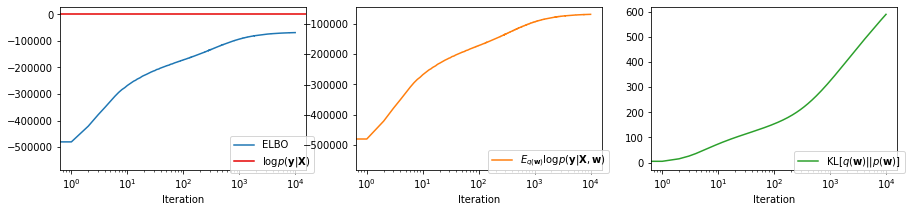

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[15, 3])

ax0.plot(elbo_summary, label="ELBO")
ax1.plot(
    lik_summary,
    color="tab:orange",
    label=r"$E_{q(\mathbf{w})} \log p(\mathbf{y}|\mathbf{X},\mathbf{w})$",
)
ax2.plot(
    kl_summary,
    color="tab:green",
    label=r"$\mathrm{KL}[{q(\mathbf{w})}||{p(\mathbf{w})}]$",
)

ax0.semilogx()
ax1.semilogx()
ax2.semilogx()

ax0.axhline(-0.4, color="xkcd:red", label=r"$\log p(\mathbf{y}|\mathbf{X})$")
ax0.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax1.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax2.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")

ax0.set_xlabel("Iteration")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Iteration")

plt.show()

> # **2.C**
> ### **Predictive distribution and evaluation**

Here I implement a function for the predictions. In particular averaging predictions at $\boldsymbol{x}_\mathrm{new}$ for all possible $\boldsymbol{w}$ through:

$$
\boldsymbol{E}_{p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}, \sigma_\mathrm{n})}h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) = \int h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}) \mathrm{d}\boldsymbol{w}
$$

In [ ]:
def predict_mh(Xt, samples):
    return 1 / samples.shape[0] * np.sum(logistic(samples @ Xt.T), axis=0)  # approximated

VI predictions are computed through:

\begin{equation}
\mathbb{E}_{q(\boldsymbol{w})}h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) = \int h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) q(\boldsymbol{w}) \mathrm{d}\boldsymbol{w}
\end{equation}

In [ ]:
def predict_y(sample_fn, q_params, Xt, rng, Nmc=10):
    """Compute the outputs of the model by sampling the posterior,
    then take the expectation
    """

    def predict_y_single(rng):
        w = sample_fn(rng, q_params)
        yp = model(w, Xt)
        return yp

    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    yp = jnp.mean(yp, axis=0)
    return yp

Log-likelihood

In [ ]:
def logistic_loglik(y, y_pred):
    return (1/len(y)) * np.sum(y * np.log(y_pred) + (1 - y)* np.log((1 - y_pred)))

Error rate

In [ ]:
def error_rate(y, y_pred):
    return (y != y_pred).sum() / len(y)

> # **2.D**
> ### **Comments on the tuning of Metropolis-Hastings algorithm and representative samples**

Metropolis-Hastings algorithm is a sequential algorithm that produces a sequence of samples – $\boldsymbol{w}_1, \boldsymbol{w}_2, \dots, \boldsymbol{w}_s, \dots$
- Imagine we’ve just produced $\boldsymbol{w}_{s-1}$
- MH firsts proposes a possible $\boldsymbol{w}_s$ (call it $\boldsymbol{\tilde w}_s$) based on $\boldsymbol{w}_{s-1}$.
- MH then decides whether or not to accept wfs
    - If accepted, pick $\boldsymbol{\tilde w}_s$
    - If not, pick $\boldsymbol{w}_{s-1}$

$\boldsymbol{\tilde w}_s$ must be treated as a random variable conditioned on $\boldsymbol{w}_{s-1}$.

The acceptance is based on the following ratio:

$$
\frac{g(\boldsymbol{\tilde w}_s; \boldsymbol y, \boldsymbol X)}{g(\boldsymbol{w}_{s-1}; \boldsymbol y, \boldsymbol X)}
\frac{p(\boldsymbol{w}_{s-1} | \boldsymbol{\tilde w}_s, \boldsymbol\Sigma_p)}{p(\boldsymbol{\tilde w}_s | \boldsymbol{w}_{s-1}, \boldsymbol\Sigma_p)}
$$

- The first term tells me that if I am moving to a point where the posterior is higher then the ratio of this term is going to be greater than 1. I can not compute the posterior, however since it is a ratio I can cancel the normalization of the posterior (which is the problem here since it is not analytically available)
- The second term penalizes eventual proposals that are too much in one direction

Also, the rules are:
- If $r \geq 1$ then accept: $\boldsymbol{w}_s = \boldsymbol{\tilde w}_s$
- If $ r < 1$ then accept with probability $r$

Rules are like this since if I only accept when  $r \geq 1$ I would be doing optimization, but instead I want to sample from this distribution. Eventually I will be sampling from $p(\boldsymbol{w} | \boldsymbol{y}, \boldsymbol{X})$ no matter the starting point.

Tuning of the parameters is very important: if I choose a very small step (doing many steps) I would end by accepting most of the steps that I did because of the ratio would be very close to 1 since I would not be moving very far from one step to another, however the samples would be highly correlated. Also, from theory the optimal acceptance rate is roughly $25 \%$ for Metropolis-Hastings.
In case the samples are very highly correlated I should keep it into account when doing expectation for predictions, keeping one every a certain amount of samples to ensure they are independent one from another.

As parameters I chose a step of size $10^{-4}$ and since it is not a very big step size I chose an high number of samples (10000). This was the result of manual grid search; these values provided me the best results.

Values that I tried were:
- number of samples: $5000, 8000, 10000$
- step size: $10^{-3} , 10^{-4}$

In order to guarantee that the samples are representative of samples of the posterior over model parameters I looked at the $\textbf{trace}$ plots that help me to understand how the samples values of a parameter change over time (iterations). Basically they told me how quickly MCMC procedure forgets its starting values and converges in distribution.

I also used $\textbf{burn-in}$ to let the Markov Chain (MCMC sampling since there is a Markov Chain underlying approach and randomness - Monte Carlo) the time to reach its equilibrium distribution. This is useful because choosing the starting point it is not easy and sometimes the starting point can be bad. This technique consists in $\textit{burning}$ (discarding) the first $n$ samples (however I could also sample for a very long time making sure to reach the equilibrium distribution without setting a burn-in).

> # **2.E**
> ### **Comments on the tuning of Variational Inference algorithm and optimization behavior**

Variational inference is another way to approximate the intractable posterior (like Laplace) which main idea is to optimization position and shape of a function $q$ to make it as close as possible to the posterior.

In particular I can write:

$$
       \log p(\boldsymbol{y}|\boldsymbol{X}) - \underbrace{\mathrm{KL}[q_{\theta}(\boldsymbol{w}) || p(\boldsymbol w|\boldsymbol y, \boldsymbol X)]}_\text{Gap between tract. and intract.} = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) - \mathbb{E}_\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]}_\text{$\mathcal{L}_{ELBO}$}
$$

So I can define in terms of KL divergence the gap between what I can comput ($\mathcal{L}_{ELBO}$) which is tractable, and what I can not compute analytically ($\log p(\boldsymbol{y}|\boldsymbol{X})$) which is intractable. In addition, I can specify that the variational objective is composed by:

$$
      \mathcal{L}(\theta) = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})}_\text{Model fitting term} -\underbrace{\mathbb{E}_\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]}_\text{Regularization term}
$$

- Model fitting term: it is the log-likelihood averaged over samples from $q$
- Regularization term: it penalizes $q_{\theta}(\boldsymbol{w})$ from being too different from the prior $p(\boldsymbol{w})$

Without regularization term the objective would put a gaussian with 0 variance with a spike which value is the value that maximize the log-likelihood (very different from the prior !)

The model fitting term is analytically available ina few cases, but I can approximate it using Monte Carlo integration. However there is a problem because with MC approximation when I resample from $q$ I would obtain a different value, for this reason I use the reparametrization trick:

$$
p(\boldsymbol z) = p(t(\boldsymbol \varepsilon;\boldsymbol \theta))
$$
Where 
$$
t(\cdot) = \boldsymbol \mu + \boldsymbol \sigma \odot \boldsymbol \varepsilon
$$
And 
$$
\boldsymbol \varepsilon \sim \mathcal{N}(\boldsymbol 0, \boldsymbol 1)
$$

In particular this means that first I sample from something $\textit easy$ as a standard normal and then I transform to get the samples from the distribution $\textit q$ multiplying by standard deviation and adding the mean and then I can use these to estimate $\log p(\textbf y | \textbf X, \textbf w)$


In Variational Inference I want to maximize the ELBO - Evidence (marginal likelihood) Lower BOund which is equivalent of minimizing the $\mathrm{KL}$ which is the gap between tractable and intractable. In particular ELBO value is equal to the intractable part when $\mathrm{KL}$ is 0 and so when posterior and approximation are equals.


There are 3 hyper parameters to be tuned in Variational Inference model:

- Nmc, number of Monte Carlo samples
- Learning rate, this is used for the ELBO's optimization (not too high to avoid too big jumps and computation errors)
- ELBO training's number of iterations of the training algorithm

Values that I tried were:
- Nmc: 100, 500, 1000
- learning rate: $10^{-3}$, $10^{-5}$
- number of iterations: 1000, 5000, 10000

Best results are the one used in the code above. Optimizer is SGD.

> # **2.F**
> ### **Report error metrics and confusion matrices**

In [ ]:
y_pred_mh = predict_mh(X_test, samples_bi)
y_pred_vi = predict_y(sample_gaussian_diagonal, q_params, X_test, rng, Nmc=1000)
print("Log-likelihood test data")
print(f"MH: {logistic_loglik(y_test, y_pred_mh)}")
print(f"VI: {logistic_loglik(y_test, y_pred_vi)}")

Log-likelihood test data
MH: -0.6669192853441462
VI: -0.6583731360341981


Function for plotting ROC curve, confusion matrix, scores and error rate

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

def roc_cm_scores_er(y, y_pred, label):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    # ROC
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    axs[0].plot(fpr, tpr,  label=label)
    axs[0].set_title("ROC curve", fontsize=20)
    axs[0].set_xlabel("False Positive Rate", fontsize=15)
    axs[0].set_ylabel("True Positive Rate", fontsize=15)
    axs[0].xaxis.set_tick_params(labelsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    # If above the optimal threshold it is mapped to 1, otherwise 0
    y_pred = y_pred >= optimal_threshold
    # Confusion matrix - I normalize values for readability
    sns.heatmap(confusion_matrix(y, y_pred, normalize='true'), annot=True, cmap="Oranges", ax=axs[1])
    axs[1].set_title("Confusion matrix", fontsize=20)
    axs[1].set_xlabel("Predicted label", fontsize=15)
    axs[1].set_ylabel("True label", fontsize=15)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    plt.show()
    print(f"The optimal threshold is at {optimal_threshold:.2f}")
    # Scores
    print(f"Accuracy score: {accuracy_score(y, y_pred):.2f}")
    print(f"F1 score: {f1_score(y, y_pred):.2f}")
    # Error rate (should be equal to 1 - accuracy score)
    print(f"Error rate: {error_rate(y, y_pred):.2f}")

    return y_pred.astype(int)  # map bool to 0/1

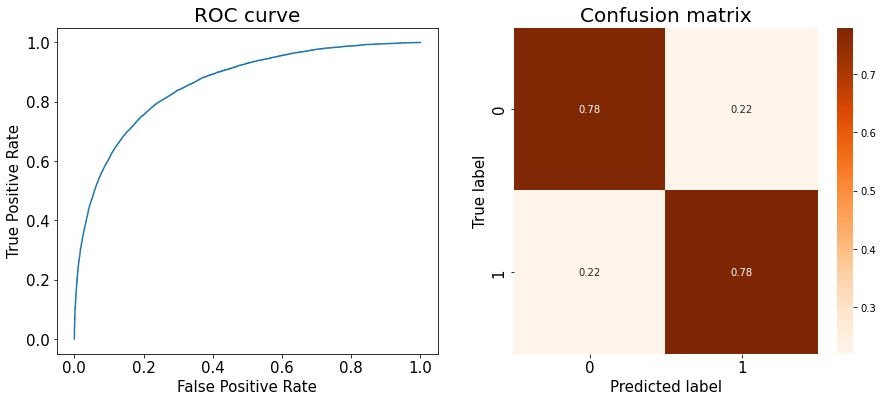

The optimal threshold is at 0.07
Accuracy score: 0.78
F1 score: 0.41
Error rate: 0.22


In [ ]:
# Bayesian Linear Regression, already plotted in point 1, but I plot again for readability of comparisons
y_pred_map_lin = roc_cm_scores_er(y_test, y_pred_lin, "Bayesian Linear Regression")

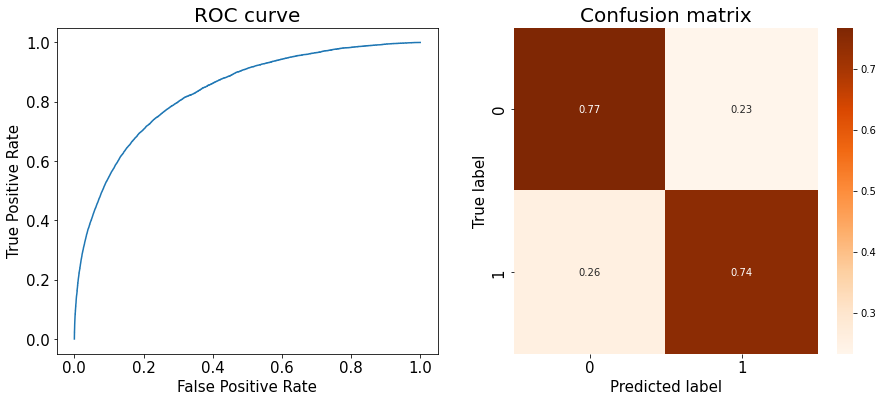

The optimal threshold is at 0.59
Accuracy score: 0.77
F1 score: 0.39
Error rate: 0.23


In [ ]:
y_pred_map_mh = roc_cm_scores_er(y_test, y_pred_mh, "Bayesian Logistic Regression - MH")

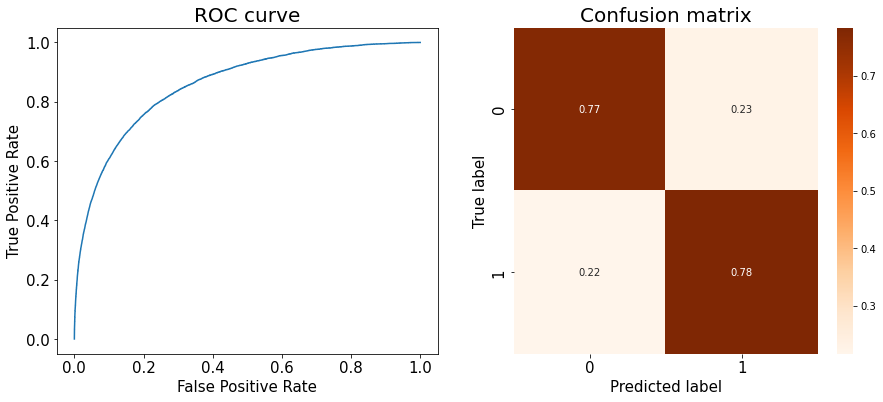

The optimal threshold is at 0.57
Accuracy score: 0.77
F1 score: 0.41
Error rate: 0.23


In [ ]:
y_pred_map_vi = roc_cm_scores_er(y_test, y_pred_vi, "Bayesian Logistic Regression - VI")

In terms of accuracy, bayesian linear regression performed slightly better than bayesian logistic regression (0.01 more of both MH and VI). It means that the number of correctly classified samples is slightly bigger in the bayesian linear regression. However, I know that accuracy is not the best metric in an unbalanced dataset, hence I look at f1-score. This score achieves the best result in linear regression and logistic regression with Variational Inference, while Metropolis Hastings is lower in terms of this weighted average of precision and recall. The number of false positives and false negatives is higher in the logistic regression with MH. 

Overall, I can see results of having a dataset with high-dimensional features and very imbalanced.

> # **2.G**
> ### **Compare uncertainty on predictions**

In [ ]:
# Alread reported above, but it is required here as well
print("Log-likelihood test data")
print(f"MH: {logistic_loglik(y_test, y_pred_mh)}")
print(f"VI: {logistic_loglik(y_test, y_pred_vi)}")

Log-likelihood test data
MH: -0.6669192853441462
VI: -0.6583731360341981


Util function to plot and compare predictive distributions

In [ ]:
def plot_pred_distributions(y_pred_1, y_pred_2):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    sns.histplot(y_pred_1, ax=axs[0])
    axs[0].set_title("MH pred. distribution", fontsize=20)
    axs[0].set_xlabel("Prediction", fontsize=15)
    axs[0].set_ylabel("Count", fontsize=15)
    axs[0].xaxis.set_tick_params(labelsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
    sns.histplot(y_pred_2, ax=axs[1])
    axs[1].set_title("VI pred. distribution", fontsize=20)
    axs[1].set_xlabel("Prediction", fontsize=15)
    axs[1].set_ylabel("Count", fontsize=15)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    plt.show()

Samples around 0.5

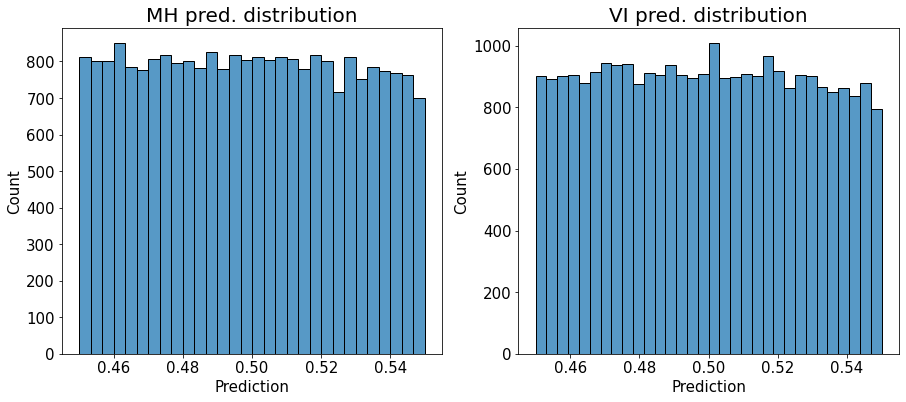

In [ ]:
samples_05_mh = y_pred_mh[(y_pred_mh >= 0.45) & (y_pred_mh <= 0.55)]
samples_05_vi = y_pred_vi[(y_pred_vi >= 0.45) & (y_pred_vi <= 0.55)]

plot_pred_distributions(samples_05_mh, samples_05_vi)

Correct prediction samples subset

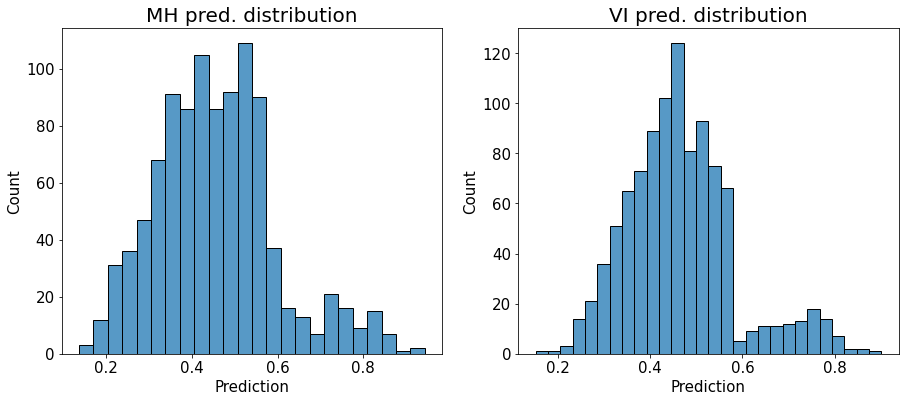

In [ ]:
np.random.seed(42)
y_corr_subset_mh = y_pred_mh[y_pred_map_mh == y_test]
y_corr_subset_vi = y_pred_vi[y_pred_map_vi == y_test]
# pick randomly 1000 samples of correct samples
y_corr_subset_mh = np.random.choice(y_corr_subset_mh, 1000, replace=False)
y_corr_subset_vi = np.random.choice(y_corr_subset_vi, 1000, replace=False)

plot_pred_distributions(y_corr_subset_mh, y_corr_subset_vi)

Wrong prediction samples subset

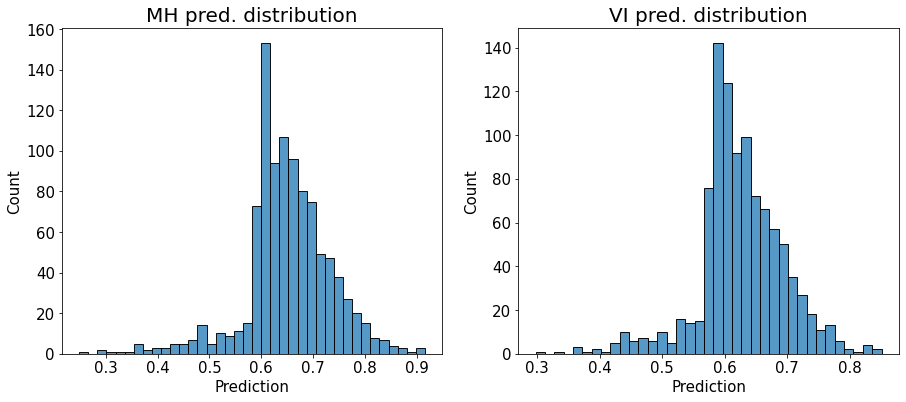

In [ ]:
y_wrong_subset_mh = y_pred_mh[y_pred_map_mh != y_test]
y_wrong_subset_vi = y_pred_vi[y_pred_map_vi != y_test]
# pick randomly 1000 samples of correct samples
y_wrong_subset_mh = np.random.choice(y_wrong_subset_mh, 1000, replace=False)
y_wrong_subset_vi = np.random.choice(y_wrong_subset_vi, 1000, replace=False)

plot_pred_distributions(y_wrong_subset_mh, y_wrong_subset_vi)

When dealing with an intractable posterior (due to the fact I can not comput the normalizing constant - i.e. the integral at the denominator) in logistic regression I can use two techniques:

- Metropolis-Hastings: it consists in sampling from the intractable posterior through a random walk
- Variational Inference: it consists in approximating the intractable posterior with something easier through optimization

Algorithms details were described in comment sections above. In terms of distributions in the above plots I can see no particular difference between the two.

> # **3 - Bonus**
> ### **Laplace approximation - Partial answer**

Laplace approximation is a technique to approximate the intractable posterior (like Variational inference) with something easier. 
A good solution is to approximate the posterior with a Gaussian:

$$
q(\boldsymbol w| \boldsymbol y, \boldsymbol X) = \mathcal{N}(\boldsymbol\mu, \boldsymbol \Sigma) 
$$
Where:
$$
\boldsymbol \mu = \hat{\boldsymbol w} , \quad \boldsymbol \Sigma^{-1} = - \nabla_{\boldsymbol w} \nabla_{\boldsymbol w} \log [g(\boldsymbol w)] |_{\hat{\boldsymbol w}}
$$
And:
$$
\hat{\boldsymbol w} = \underset{a}{\operatorname{argmax}} \log [g(\boldsymbol w)]
$$
Which is already known from the MAP estimate (through numerical optimization like Newton-Raphson)

When doing predictions it is needed to compute:

$$
\mathbf{E}_{\mathcal{N}(\boldsymbol \mu, \boldsymbol \Sigma)}[P(y_* = 1 | \boldsymbol x_*, \boldsymbol w)] = \int \mathcal{N}(\boldsymbol \mu, \boldsymbol \Sigma) \frac{1}{1 + exp(-\boldsymbol w^T \boldsymbol x_*)}d\boldsymbol w
$$

However I can not compute this integral so I sample from $\mathcal{N}(\boldsymbol \mu, \boldsymbol \Sigma)$ obtaining:

$$
\mathbf{E}_{\mathcal{N}(\boldsymbol \mu, \boldsymbol \Sigma)}[P(y_* = 1 | \boldsymbol x_*, \boldsymbol w)] \approx \frac{1}{S} \sum_{s=1}^{S} \frac{1}{1 + exp(-\boldsymbol w^T \boldsymbol x_*)}
$$

Since Laplace uses a distribution over decision boundaries it has less certainty and it is more sensible with respect to point prediction and it has higher complexity.

In general Laplace approximation allows some bad decision boundaries with respect to Metropolis-Hastings due to the Gaussian approximation.


As suggestion to improve the result it could be useful to rebalance the dataset as suggested at the beginning of this work. A technique could be SMOTE (oversampling) but also undersampling could be performed. However, I have to be careful since oversampling may introduce redundant data (if I simply copy instances of minority class) and undersampling would cause a reduction in the number of data (original distribution of target class was 90/10)